<img src="https://unlearning-challenge.github.io/Unlearning-logo.png" width="100px">

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from typing import Optional,List,Tuple
import random


SEED =2023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [2]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=False, num_workers=4)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.2, 0.8])
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# download pre-trained weights
response = requests.get(
    "https://unlearning-challenge.s3.eu-west-1.amazonaws.com/weights_resnet18_cifar10.pth"
)
open("weights_resnet18_cifar10.pth", "wb").write(response.content)
weights_pretrained = torch.load("weights_resnet18_cifar10.pth", map_location=DEVICE)
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

"""
print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%%")
""";

In [4]:
#altering the model with specific parameters inspired form torch resnet

class BasicBlock(nn.Module):
    def __init__(self,in_planes:int,out_planes:int,kernel_size:int=3,stride:Optional[int]=None,groups:int=1,padding:Optional[str]="same"):
        super().__init__()
        # Conv3D
        self.conv1 = nn.Conv2d(in_planes,out_planes,kernel_size=kernel_size,groups=groups,padding=1,dilation=1,stride=stride)
        self.conv2 = nn.Conv2d(out_planes,out_planes,kernel_size=kernel_size,groups=groups,padding=1,dilation=1,stride=1)
        #what happens if inplanes and outplanes are not the same. how do we perform sum.
        #What happens if HXW changes. 
        #authors propose the idea of zero padding, to the input and not the output. planes will grow but H and W will shrink
        self.downsample =None
        if stride!=1 or in_planes !=out_planes:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=stride,bias=False),nn.BatchNorm2d(out_planes))
        # LayerNorm
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        #activation of relu
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        
        out = x
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
      

        #to match diamensions of x with that of output.
        if self.downsample:
            x = self.downsample(x)
        
        out += x
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self,block_config:List[Tuple[int]],num_classes:int):
        super().__init__()
        
        self.in_planes = block_config[0][1]
        self.out_layer = block_config[-1][1]

        self.conv1 = nn.Conv2d(3,self.in_planes,kernel_size=1,bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    

        self.layers = nn.Sequential(*self.make_blocks(block_config))
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.out_layer,num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                

    def forward(self,x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.maxpool(out)

        
        for layer in self.layers:
            out = layer(out)
            
        out = self.avg_pool(out)
        out = nn.Flatten()(out)
        out = self.fc(out)
        return out
    

    
    def make_blocks(self,block_config:List[Tuple[int]]):
        blocks= []
        in_planes = self.in_planes
        for b,out_planes in block_config:
            blocks.append(BasicBlock(in_planes,out_planes,stride=2))
            for _ in range(b) :
                blocks.append(BasicBlock(out_planes,out_planes,stride=1))
            in_planes = out_planes
        return blocks


In [5]:
#pretrained one
# load model with pre-trained weights

model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

#else we will try our implementation and train again
net = ResNet([(2,8)],10)
net.to(DEVICE);

In [6]:
#training a model
from tqdm.notebook import tqdm
# to track all the losses and other parameters. start with loss and accuracy.
class AverageMeter():
    def __init__(self):
        pass

def train(net, train_loader, val_loader,metrics):

    epochs = 10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for _ in tqdm(range(epochs)):
        net.train()

        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            train_loss +=loss.item()
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        metrics["train_loss"].append(train_loss / len(train_loader))

       
        #validation loss
        net.eval()
        
        val_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)  
            val_loss +=loss.item() 
        
        metrics["val_loss"].append(val_loss / len(train_loader))
        metrics["train_accuracy"].append(accuracy(net, train_loader))
        metrics["val_accuracy"].append(accuracy(net, val_loader))

    return net

metrics = {"train_loss":[],"val_loss":[],"train_accuracy":[],"val_accuracy":[]}
model = train(net,train_loader,val_loader, metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

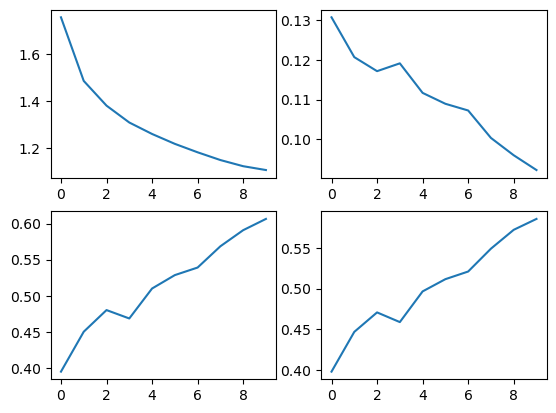

In [7]:
#plot metrics
fig,ax = plt.subplots(2,2)
ax[0,0].plot(metrics["train_loss"])
ax[0,1].plot(metrics["val_loss"])
ax[1,0].plot(metrics["train_accuracy"])
ax[1,1].plot(metrics["val_accuracy"])

Let us show some of the training images, just for fun.

Files already downloaded and verified


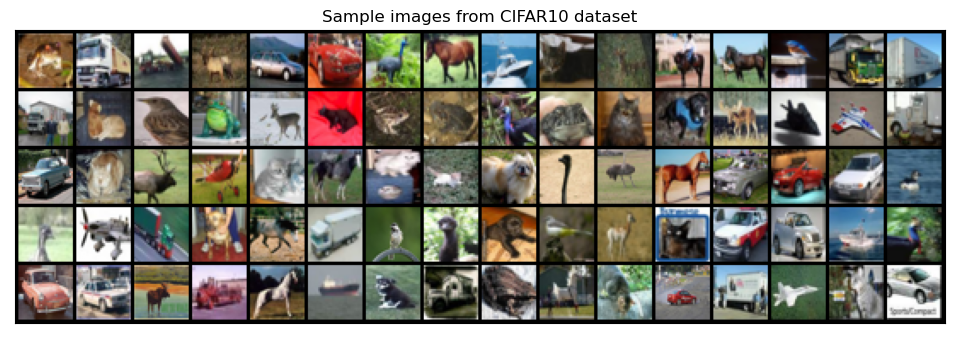

In [8]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

We'll now compute the model's accuracy on the train and test set. This model has been trained without data augmentation, so generalization accuracy is lower than state-of-the-art models.


# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

We start by splitting the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

In [6]:
forget_set, retain_set = torch.utils.data.random_split(train_set, [0.1, 0.9])
forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=2
)

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained and optimizes for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient.

To make a new entry in the competitions, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [7]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [8]:
"""
model_ft = resnet18(weights=None, num_classes=10)
model_ft.load_state_dict(weights_pretrained)
model_ft.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
model_ft = unlearning(model_ft, retain_loader, forget_loader, test_loader)
"""
model_ft = model

We have now an unlearned model `model_ft`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [9]:
print(f"Retain set accuracy: {100.0 * accuracy(model_ft, retain_loader):0.1f}%%")
print(f"Test set accuracy: {100.0 * accuracy(model_ft, test_loader):0.1f}%%")

Retain set accuracy: 99.5%%
Test set accuracy: 90.0%%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [10]:
def compute_losses_and_logits(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []
    all_logits = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
       
        for loss,logit in zip(losses,logits):
            all_losses.append(loss)
            all_logits.append(logit.numpy(force=True))

    return np.array(all_losses),np.array(all_logits)


train_losses,train_logits = compute_losses_and_logits(model, train_loader)
test_losses,test_logits = compute_losses_and_logits(model, test_loader)

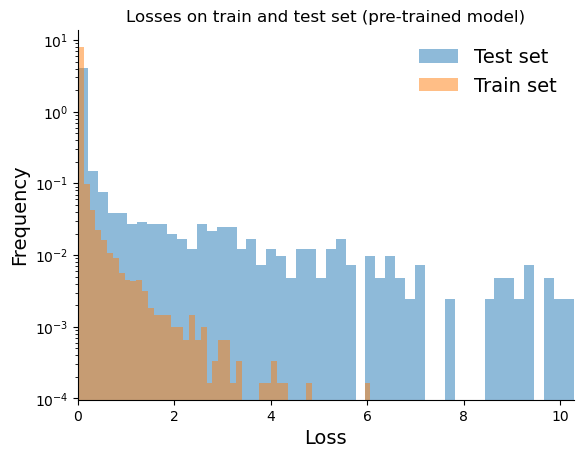

In [11]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes. 

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set (associated with an attacker accuracy around random chance).

In [33]:

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

class MiaBaseModel(nn.Module):
  def __init__(self,in_features,out_features) -> None:
      super().__init__()
      self.linear = nn.Linear(in_features=in_features,out_features=out_features)
      self.bn = nn.BatchNorm1d(out_features)
      self.relu = nn.ReLU()

  def forward(self,x):
      out = self.linear(x)
      out = self.bn(out)
      out = self.relu(out)
      return out
      

class MiaModel(nn.Module):
    def __init__(self,model_config:List[int],num_classes:int,pretrained_model=None) -> None:
        super().__init__()
        self.model_config= model_config
        self.num_classes = num_classes

        self.layers = nn.Sequential(*self.make_layers(model_config+[num_classes]))
        self.softmax = nn.Softmax(dim=1)
        self.epocs = 500
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.epocs)
        if pretrained_model is not None:
            self.load_state_dict(torch.load(pretrained_model))

    def make_layers(self,model_config):
        layers = []
        in_channel = model_config[0]
        for out_channel in model_config[1:]:
            layers.append(MiaBaseModel(in_channel,out_channel))
            in_channel = out_channel
        return layers
            
    def forward(self,x):
      out = x
      for l in self.layers:
          out = l(out)
        
      out =  self.softmax(out)
      return out
    
    def fit(self,train_dataset,y=None):
      self.to(DEVICE)
      self.train()
      train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True,num_workers=2)
      for _ in range(self.epocs):
        for inputs,targets in train_dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            self.optimizer.zero_grad()
            outputs = self(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
      return self
    def predict(self,X):
        return torch.argmax(self(X),dim=1)

    def get_params(self,deep=True):
        torch.save(self.state_dict(),"mia.pt")
        return  {"model_config":self.model_config,"num_classes":self.num_classes,"pretrained_model":"mia.pt"}
    def set_params(self, **params):
        self.load_state_dict(torch.load(params["pretrained_model"]))

from sklearn.model_selection import StratifiedShuffleSplit

def accuracy(model,val_dataset,y=None):
        
    model.eval()
    val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=True,num_workers=2)
    total_correct,total_count = 0,0
    for inputs,targets in val_dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        accuracy = (model.predict(inputs) == targets).sum() 
        total_correct += accuracy
        total_count += len(targets)
    return total_correct / total_count



class TorchStratifiedShuffleSplit:
    def __init__(self,n_splits:int=5,random_state:int=0):
        self.n_splits = n_splits
        self.random_state = random_state
    def get_n_splits(self, X):
        return self.n_splits

    def split(self, dataset,y=None,groups=None):
        cv = StratifiedShuffleSplit(n_splits=self.n_splits,random_state = self.random_state)
        args  =    zip(*[(i,y) for i,(X,y) in enumerate(dataset)])
        for train_idx, val_idx in iter(cv.split(*args)):
            yield train_idx,val_idx
                                       
    
class SimpleDataSet(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y) 
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        return self.X[index],self.y[index]
        
  
def neural_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")
    #any fully connected classification model will do the job
    attack_model = MiaModel([10,15,15,20],5)
    cv =TorchStratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    #cv  = TorchStratifiedShuffleSplit(5,10)
    return model_selection.cross_val_score(
        attack_model, SimpleDataSet(sample_loss,members), members, cv=cv, scoring=accuracy
    )

In [46]:
X = np.random.rand(100,10)
w  = np.random.rand(10,1)
y = X @ w
y = np.squeeze((y > y.mean()).astype(int),axis=1)
mia_scores = neural_mia(X, y,n_splits=2)
print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [117]:
_, forget_losses = compute_losses_and_logits(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.seed(SEED)
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_logits, forget_losses))#.reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)


#dont trust neural_mia code write some test cases to validate.
mia_scores = neural_mia(samples_mia, labels_mia,n_splits=2)
print(
f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

Exception ignored in: <function _releaseLock at 0x7f65010e0280>
Traceback (most recent call last):
  File "/research/hal-gaudisac/anaconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


The MIA attack has an accuracy of 0.548 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [63]:
ft_forget_losses = compute_losses(model_ft, forget_loader)
ft_test_losses = compute_losses(model_ft, test_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.seed(SEED)
np.random.shuffle(ft_forget_losses)
ft_forget_losses = ft_forget_losses[:len(ft_test_losses)]

samples_mia_ft = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)    

In [9]:
mia_scores_ft = neural_mia(samples_mia_ft, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores_ft.mean():.3f} on forgotten vs unseen images"
)

NameError: name 'samples_mia_ft' is not defined

From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

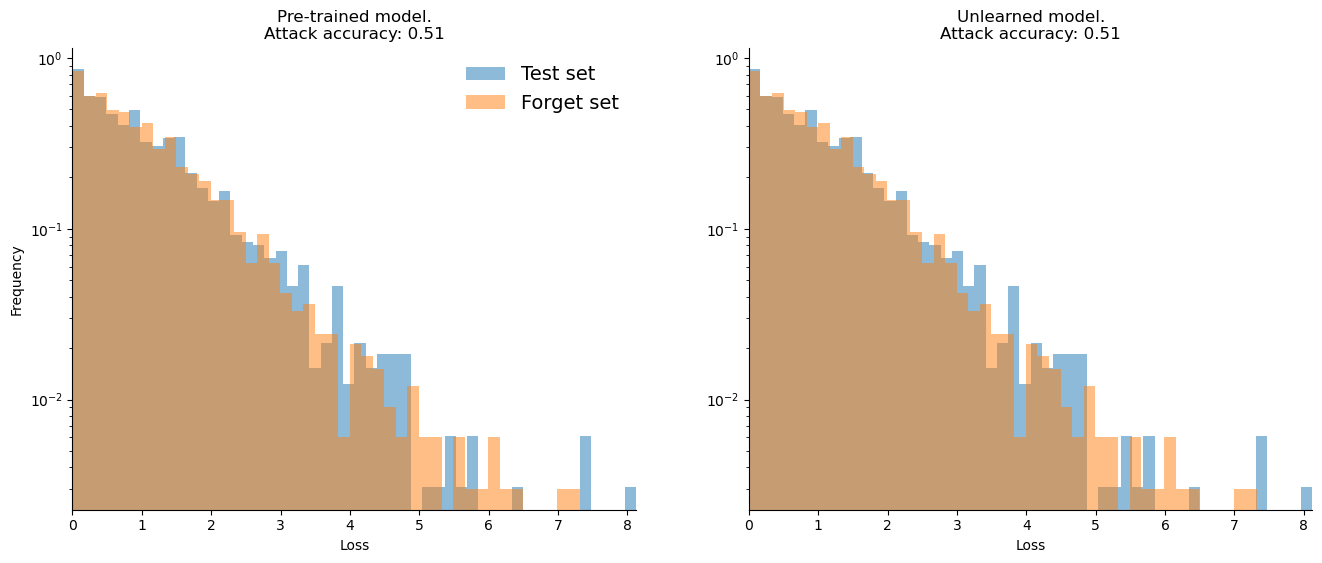

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(f"Unlearned model.\nAttack accuracy: {mia_scores_ft.mean():0.2f}")
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
data_before = np.load("results/before_logits.npz")
data_after = np.load("results/after_logits.npz")

0.68575
tensor([[2.1273e-05, 5.8871e-07, 3.7361e-05,  ..., 3.6776e-06, 2.1282e-05,
         5.6612e-05],
        [1.7797e-04, 5.5788e-05, 3.8373e-03,  ..., 4.4885e-02, 1.5234e-06,
         9.4508e-01],
        [1.3208e-09, 1.5988e-12, 4.0055e-10,  ..., 1.0000e+00, 6.0814e-13,
         9.7314e-09],
        ...,
        [1.6695e-03, 9.3539e-03, 8.1020e-03,  ..., 2.3256e-05, 5.4207e-02,
         1.5684e-03],
        [5.4092e-04, 2.7288e-05, 8.1774e-05,  ..., 8.8216e-04, 3.3397e-06,
         1.9696e-07],
        [1.5089e-02, 4.4364e-02, 2.7040e-01,  ..., 4.7082e-03, 5.9206e-01,
         2.2059e-02]], device='cuda:1')
tensor([[4.5281e-03, 1.0611e-05, 5.2585e-03,  ..., 2.5392e-03, 7.1615e-01,
         2.1735e-03],
        [2.4372e-02, 4.5847e-04, 1.0953e-02,  ..., 1.8683e-02, 3.1738e-04,
         1.5484e-03],
        [9.9988e-01, 1.8672e-06, 4.1591e-05,  ..., 4.8819e-08, 4.4972e-06,
         7.9327e-08],
        ...,
        [3.1279e-07, 7.6095e-05, 1.0987e-11,  ..., 1.4510e-07, 3.4039e-09,


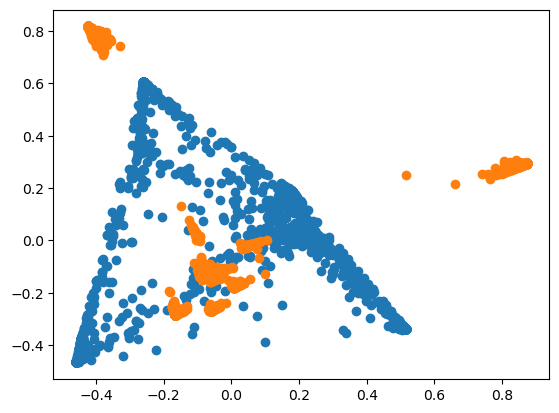

0.49325
tensor([[4.5093e-05, 5.5555e-06, 5.8268e-06,  ..., 1.4935e-04, 1.9606e-06,
         9.9950e-01],
        [9.6567e-05, 1.5158e-03, 3.0166e-04,  ..., 3.0181e-05, 3.8461e-04,
         1.1779e-05],
        [1.6431e-04, 5.1585e-05, 1.7707e-04,  ..., 1.1445e-01, 4.6720e-03,
         1.3327e-05],
        ...,
        [1.0949e-03, 2.5847e-04, 5.6210e-06,  ..., 4.0291e-05, 1.9161e-04,
         1.1754e-05],
        [7.9259e-02, 1.0060e-02, 1.3369e-03,  ..., 2.2065e-04, 4.0294e-05,
         9.0889e-01],
        [1.8097e-06, 3.7665e-03, 5.4725e-08,  ..., 7.1481e-06, 1.8542e-06,
         9.9622e-01]], device='cuda:1')
tensor([[2.6848e-06, 1.4042e-06, 2.2686e-07,  ..., 1.2400e-06, 4.6941e-06,
         2.2187e-07],
        [2.6617e-05, 3.7532e-06, 2.7054e-03,  ..., 4.7406e-06, 1.1243e-05,
         8.7793e-06],
        [3.7463e-06, 3.5545e-07, 7.4061e-03,  ..., 8.6362e-07, 4.6716e-08,
         3.6361e-06],
        ...,
        [6.2733e-09, 4.1050e-06, 3.2497e-07,  ..., 2.1644e-08, 2.4799e-06,


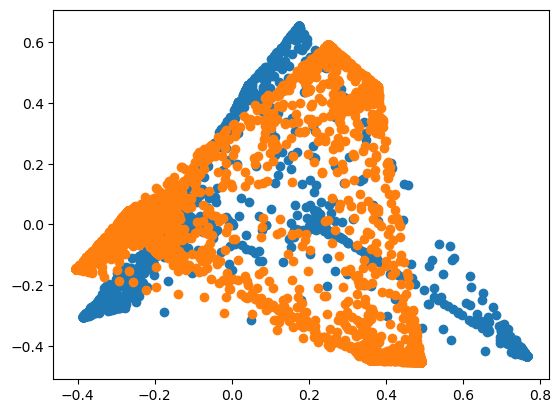

In [85]:
#import PCA
from sklearn.decomposition import PCA
#import softmax
from scipy.special import softmax
#xg boost base classifier from sklearn
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from  xgboost import XGBClassifier as xgb
from sklearn.model_selection import cross_validate

from score import neural_mia, simple_mia
from network import MiaModel

params = {
            'objective':'binary:logistic',
            'max_depth': 10,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }


for data in [data_before,data_after]:
    model = xgb(**params)
    X  = np.vstack((softmax(data['test_logits'],axis=1),softmax(data["forget_logits"][:2000],axis=1)))
    y = np.concatenate((np.zeros(len(data['test_logits'])),np.ones(len(data["forget_logits"][:2000]))))
    results = cross_validate(model,X,y,cv=5)
    print(results['test_score'].mean())
    pca = PCA(2)

    attack_model = MiaModel([10,7,4,2],2)
    mia_scores = neural_mia( X, y ,attack_model, n_splits=2)
    print(mia_scores.mean())

    U = pca.fit_transform(softmax(data['test_logits'],axis=1))
    V = pca.fit_transform(softmax(data['forget_logits'],axis=1))
    plt.scatter(U[:,0],U[:,1])
    plt.scatter(V[:,0],V[:,1])
    plt.show()
    attack_model = MiaModel([10,15,15,20],2)
